In [1]:
#import needed modules
import simpy
import numpy as np
import random
import math
import simpy.rt
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh') #pretty plots
plt.rcParams['figure.figsize']=(15,15)

In [2]:
RANDOM_SEED = 42

W  = '\033[0m'  # white (normal)
H  = '\033[1m'
R  = '\033[31m' # red
G  = '\033[32m' # green
O  = '\033[33m' # orange
B  = '\033[34m' # blue
P  = '\033[35m' # purple

In [3]:
"""
    Create class object to serve as the rooting table for mapping out node in the network
"""
class network_layout(object):
    def __init__(self, homeID, rows, cols):
        self.homeID = homeID
        self.node_count = 0
        self.successes = 0
        self.collisions = 0
        self.rows = rows
        self.cols = cols
        self.layout = np.zeros([rows, cols])
        self.coordinates = []
        self.wall_coordinates = []
        self.distances = []
        self.margins = []
        self.node = []
        self.broadcast = []
        self.rooting_table = []
        self.message_ID = 0
        self.walls = []
        self.border = []
        self.wall_count = 0
        self.baud_rate = 9600
        self.max_bytes = 54
        self.max_retransmissions = 2
        self.maxCCA = 1100
        self.min_ACK_wait = 18.5
        self.preamble = 10
        self.SOF = 1
        self.start = []
        
        # Specify latencies observed from physical modelling
        self.delay_Queue = 4.45
        self.delay_receiver = 4.981
        self.delay_TX_to_RX = 0.5
        self.delay_RX_to_TX = 0.5
        self.delay_Routing = 10.273
        
    
        
    def addNode(self, env, x, y, homeID, role):
        # Increment number of nodes included in the network
        count = self.node_count
        new_node = count+1
        
        # Add new node to 2D representation of physical grid, provided the location does not contain another node
        if(self.layout[x][y] == 0):
            self.layout[x][y] = new_node
        self.node.append(Node(env, homeID, new_node, [x,y], role))
        
        # Store the coordinates of the new node
        self.coordinates.append([x,y])
        
        # Increment number of nodes included in the network
        self.node_count = self.node_count+1
        
        # Determines the number of obstacles a node packet from the included node would collide with during 
        # packet transmission to all neighbouring nodes
        self.find_walls(self.node_count)
        
        # Add a broadcast object and transmit a broadcast packet to determine neighbouring nodes
        self.broadcast.append(Broadcast(env))
        env.process(self.request_NIF(self.node[self.node_count-1]))
        
        # Utilize knowledge of neighbouring nodes to update the rooting table available to the controller
        self.update_rooting_table()
        
        # Utilize the rooting table to the primary controller to identify all routes  between included nodes
        self.sense_routes()
        self.update_routing_knowledge()                    
        
        
    def request_NIF(self, node):
        # Determine neighbouring nodes
        neighbour_list = []
        i = node.nodeID-1
        for j in range (0, (self.node_count)):
            if(j != i):
                target = self.node[j]
                margin = self.link_margin(node, target)
                if(margin > 0):
                    neighbour_list.append(self.node[j].nodeID)
        header = 1
        # target = 255 indicates a broadcasted packet to be transmitted to all included nodes
        target = 255
        
        # Construct message packet
        path = np.array([(i+1),255])
        msg = self.construct_packet(header, self.message_ID, path)
        neighbour_list = np.array(neighbour_list)
        count = neighbour_list.size
        flag = True
        
        # Call method to transmit the broadcasted packet
        env.process(self.send_broadcast(env, neighbour_list, msg))
        
        # Wait sufficiently long for the broadcasted packet to be  transmitted and acknowledged
        yield env.timeout(50)
        k=0
        box = []
        for k in range(0, count):
            box.append(self.broadcast[i].channel[k].get())
            current_neighbour = neighbour_list[k]
            
            # Call method which yields to the event that a neighbouring node responds to the broadcasted packet
            env.process(self.NIF_ack(env, box[k], i, current_neighbour))
            
    # Method which is triggered in the event that a neighbouring node responds to the broadcasted NIF frame
    def NIF_ack(self, env, event, i, k):
        time_limit = env.timeout(20)
        response = yield event|time_limit
        if(event in response):
            self.node[k-1].RX = True
            self.node[k-1].TX = False
            
            # Add the sender of the response to the list of recognised neighbours
            visible_neighbours = self.broadcast[i].neighbours
            visible_neighbours.append(k)

    # Method which updates a nodes knowledge of routing alternative within the network according to its role in the network
    def update_routing_knowledge(self):
        i=0
        count = self.node_count
        for i in range (0, count):
            current_node = self.node[i]
            
            # The primary controller has access to the full rooting table
            if (current_node.role == 0):
                current_node.routing_knowledge = self.rooting_table
                
            # Routing slaves have knowledge of routing alternatives accessed through their neighbouring nodes
            elif(current_node.role == 1):
                current_node.routing_knowledge = self.rooting_table[count-1]
                
            # Dedicated slaves have no routing knowledge and only respond to the sender of a received packet
            elif(current_node.role == 2):
                current_node.routing_knowledge = []
                
    # Method which determine all routing alternatives for all nodes included in the network
    def sense_routes(self):
        count = self.node_count
        i=0
        j=0
        for i in range (0, count):
            box = []
            for j in range(0, count):
                options = []
                if(i!=j):
                    origin = i
                    target = j
                    ref = i
                    history = np.array([origin])
                    
                    # Determine all routing alternatives to reach the intended receiver from the current sending node
                    self.investigate_route(history, origin, target, ref, options)
                routes = np.array(options)
                if((j==0) and (options != [])):
                    box = [options]
                else:
                    box.append(options)
            box = np.array(box)
            self.node[i].set_routes(box)
            
    # Method which is recursively called in order to investigate the validity of a possible routing alternative
    def investigate_route(self, history, current, target, ref, options):
        k=0
        count = self.node_count
        while(k<count):
            role = self.node[current].role
            
            # Only consider routing alternatives accessible through neighbouring nodes
            if(self.rooting_table[current][k] == 1):
                flag = False
                
                # A single node cannot occur more than once in a route
                if (k in history):
                    flag = True
                if(flag == False):
                    
                    # If the current neighbour in question is the intended receiver, terminate recursion and save the route
                    if(k==target):
                        answer = np.hstack([history, [k]])
                        answer = answer + 1
                        options.append(answer)
                        
                    # Recursively investigate the possible route
                    else:
                        part2 = np.hstack([history, [k]])
                        self.investigate_route(part2, k, target, ref, options)
            k=k+1
        

    #Update rooting table storing neighbouring nodes which are available to route packets
    def update_rooting_table(self):
        count = np.array(self.node).size
        grid = np.zeros([count, count])
        #maximum distance a packet can be transmitted
        j=0
        k=0
        for j in range(0,count):
            A=self.node[j]
            for k in range(0, count):
                if (j != k):
                    B=self.node[k]
                    margin = self.link_margin(A,B)
                    if(margin > 0) :
                        grid[j][k] = 1
                else:
                    grid[j][k] = 0
        self.rooting_table = grid
        
    # Method to returns the coordinates of all nodes within the network
    def getCoordinatesOfNodes(self):
        coord = np.array(self.coordinates)
        return coord
        
    # Method which returns the distance between all nodes in the network
    def getDistances(self):
        coordinates = self.getCoordinatesOfNodes()
        distances = np.zeros([self.node_count, self.node_count])
        i=0
        j=0
        for i in range (0,(self.node_count)):
            for j in range (0, (self.node_count)):
                x_difference = coordinates[i][0] - coordinates[j][0]
                y_difference = coordinates[i][1] - coordinates[j][1]
                distances[i][j] = math.sqrt(math.pow(x_difference,2) + math.pow(y_difference,2))
        self.distances = distances
        return distances
    
    def getMargins(self):
        i=0
        j=0
        margins = np.zeros([self.node_count, self.node_count])
        for i in range (0,(self.node_count)):
            A = self.node[i]
            for j in range (0, (self.node_count)):
                if(i != j):
                    B = self.node[j]
                    margins[i][j] = self.link_margin(A,B)
        self.margins = margins
        return margins
        
    # Get method which returns the number of nodes currently included in the network
    def getNodeCount(self):
        return self.node_count
    

    # Set method which updates the current number of nodes included in the network
    def setNodeCount(self, value):
        self.node_count = value
        
    # Set method which updates the distance matrix storing the distance between all nodes in the network
    def updateDistances(self):
        self.distances = self.getDistances()
        
    # Get method which return the full rooting table matrix of the network
    def getLayout(self):
        return self.layout
    
    def increment_successes(self):
        self.successes = self.successes + 1
        
    def increment_collisions(self):
        self.collisions = self.collisions + 1
        
    def get_successes(self):
        return self.successes
    
    def get_collisions(self):
        return self.collisions
    
    def show_grid(self):
#         print(B+'Physical Grid'+H)
        
        count = roots.node_count
        nodes = np.arange(count)
        nodes = nodes+1
        points = nodes.tolist()
        ids = points
        pos = np.array(roots.coordinates)
        plt.figure(figsize=(10,10))
        for c, i, count in zip("rgbymwc", ids, ids):
            plt.scatter(pos[nodes == i, 0], pos[nodes == i, 1], s=250, c=c, label=count)
        plt.title('\nPhysical Network Layout', fontsize=24)
        plt.ylabel('Y Coordinate [m]', fontsize=24)
        plt.xlabel('X Coordinate [m]', fontsize=24)
        plt.tick_params(labelsize=20)
        wc = roots.wall_coordinates
        plt.scatter(wc[:, 0], wc[:, 1], s=25, c="k", label='Walls')
        plt.legend(loc=4)
        plt.show()
        
        print(B+'\nCoordinates of nodes'+H)
        coco = self.getCoordinatesOfNodes()
        print(coco)
        print(B+'\nNumber of nodes: %d\n'%self.getNodeCount()+H)
        print(B+'\nDistance between nodes'+H)
        didi = self.getDistances()
        print(didi)
        print(B+'\nLink margins'+H)
        marge = self.getMargins()
        print(marge)
        print(B+'\nRooting table'+H)
        print(self.rooting_table)
        print(B+'\nAvailable Routes'+H)
        count = self.node_count
        i=0
        j=0
        for i in range(0, count):
            print(B+'\nRoutes from node %d'%(i+1)+H)
            for j in range(0, count):
                if(i!=j):
                    print('\nNode %d - Node %d: '%(i+1,j+1))
                    hits = np.array(self.node[i].routes[j])
                    r = hits.shape
                    t=0
                    for t in range(0, r[0]):
                        print(hits[t])
        print(B+'\nWall Grid:\n'+H)
        for i in range (0,count):
            print(self.node[i].walls)
    
    # Method which determines the straight line distance between nodes when routing information from A to B
    def distance_of_path(self, path):
        path = np.array(path)
        nodes = path.size
        distance = 0
        i=0
        dtt = self.getDistances()
        for i in range (0, (nodes-1)):
            A=path[i]
            B=path[i+1]
            distance = distance + dtt[A-1][B-1]
        return distance.round()
        
        
    
    # Method which calculates the distance between 2 nodes
    def calc_distance(self,A,B):
        A = A.nodeID
        B = B.nodeID
        dtt = self.getDistances()
        distance = (dtt[A-1][B-1]).round()
        return distance
    
    def determine_routing(self, env):
        print()
        self.start.append(env.now)
        A1 = (int)(input('Start Node: '))
        B1 = (int)(input('Target Node: '))
        print(B+'\nNew transmission attempt \nMessage ID: %d \nSender: Node %d \nTarget: Node %d\n'%((self.message_ID+1), A1, B1)+H)
        i=0
        message = len(self.node[0].command_set)
        command = self.node[0].command_set[message-1]
        # Simulate the time delays associated with queueing packets at the primary controller
        for i in range(0,2):
            yield env.timeout(self.delay_Queue)
        count = command.count
        for i in range(0, count):
            self.message_ID = self.message_ID + 1
            CCA_duration = 0
            self.initiate_transmission(env,A1,B1,self.message_ID, CCA_duration)
            yield env.timeout(0.5)
            
        
    # Extract routing information from user and intitialize packet transmission
    def initiate_transmission(self, env, A, B, message_ID, CCA_duration):
        path = np.array(self.best_routes(A,B))
        origin = self.node[A-1]
        
        # If the sending node is not currently awaiting acknowledgement and the maximum allowed CCA has not expired, transmit
        if((origin.CCA == False) and (CCA_duration < 1100)):
            origin.CCA = True
            env.process(self.manage_transmission(env, path, message_ID))
            
        # Continue to wait
        elif(CCA_duration < 1100):
            env.process(self.waiting_for_ack(env, A,B, message_ID, CCA_duration))
            
        # Failed Node
        else:
            origin.message.succeed(2)
            origin.message = env.event()
            
    # Construct the frame to be transmitted according to the ITU-T G.9959 standard
    def construct_packet(self, header, message_ID, path):
        command_length = 0
        if(self.node[0].command_set == []):
            command_length = 4
        else:
            command = self.node[0].command_set[0]
            state = command.progress
            command_length = command.commands[state]
        hops = path.size - 1
        A=path[0]
        B=path[hops]
        routed=0
        data = (np.arange(command_length)).tolist()
        if(header==3):
            data = command.acks[state]
        if(hops > 1):
            j=0
            repeaters = [B, hops]
            for j in range (1,(hops)):
                repeaters.append(path[j])
#             repeaters = np.array(repeaters)
            B=repeaters
            routed = 1
            if(header != 3):
                header = 8
        
        checksum = 1
        power = 0
        speed = 0
        beaming = 0
        ack_req = 1
        frame_header = Frame_Header(routed, ack_req, power, speed, header, beaming, message_ID)
        length = self.determine_packet_size(B, routed, data)
        msg = Frame(self.homeID, A, frame_header, length, B, data, checksum)
        return msg
        
        
    def manage_transmission(self, env, path, message_ID):
        i=0
    
        possibilities = path.size
        flag = False
        time_at_transmission = env.now
        
        # Simulate the time delays associated with routing packets at the primary controller
        yield env.timeout(self.delay_Routing)
        
        while((flag == False) and (i<possibilities)):
            command = self.node[0].command_set[0]
            state = command.progress
            order = command.count-1
            header=1
            
            pathway=0
#             if(possibilities>1):
#                 pathway = i
    
            # Construct the packet
            msg = self.construct_packet(header, message_ID, path[pathway])
            distance_to_travel = self.distance_of_path(path[pathway])
            time_allowance = 500
            
            # Initialize packet transmission
            env.process(self.packet_transmission(env, msg))
            host_id = path[pathway][0]
            host = self.node[host_id-1]
            
            # Create events to be triggered indicating ack reception or time expired
            event1, event2 = host.message, env.timeout(time_allowance, value='slow')
#             time_at_transmission = env.now
            
            # yield the union of the events
            response = yield event1|event2
            time_at_reception = host.transmission_time
            host.transmission_time = 0
            RTT = round(env.now - time_at_transmission,3)
            message_ID = msg.frame_header.sequence
            
            # Process the received ack accordingly
            if((response == {event1: 1}) and (RTT>self.min_ACK_wait)):
                flag=True
                queue_count = host.waiting_list.count
                print('queue count: ',queue_count)
#                 if (queue_count == 0):
                host.CCA = False
                print(G+'\nTransmission Successful \nMessage ID: %d\n'%message_ID+H)
                print(G+'Round Trip Time: ',RTT, ' ms '+H)
                if(state == order):
                    # Trigger the event that the message arrived successfully
                    command.command_complete.succeed(1)  
                    
                    # Trigger the event that the next transmission request in the queue must be executed
                    command.command_complete = env.event()
                else:
                    command.progress = command.progress + 1
            elif(response == {event2: 'slow'}):
                print(R+'No Packet Received, try again'+H)
                i=i+1
            elif(response == {event1: 0}):
                print(R+'COLLISION! Packet Dropped\n'+H)
                i = possibilities
            elif(response == {event1: 2}):
                print(R+'CCA FAILURE!\n'+H)
                i = possibilities
        if(flag == False):
            print(R+'\nTransmission Unsuccessful \nMessage ID: %d\n'%message_ID+H)
    
            
        
    # Sender method which transmits a message from node A to node B synchronously after yielding a certain period of time
    def sender(self, env, origin, target, msg):
        header = msg.frame_header.header
        if((header == 1) or (header == 8)):
            comment = ('Message sent from %d to %d at %d'%(origin.nodeID, target.nodeID, env.now))
        elif(header == 3):
            comment = ('ACK sent from %d to %d at %d'%(origin.nodeID, target.nodeID, env.now))
            
        # Perform CCA
        if((origin.TX==False) and (target.RX==True) and (target.TX==False)):
            origin.TX = True
            origin.RX = False
            
            # Determine and yield the time delay associated with the transmission of bits from sender to receiver according to symbol rate
            packet_size_bits = 8 * (msg.length+self.preamble+self.SOF)
            delay_transmission = (packet_size_bits / self.baud_rate * 1000)
            yield env.timeout(delay_transmission)
            
            # Determine the likelihood of successful packet transmission
            random = np.random.random_sample()
            margin = self.link_margin(origin, target)
            likelihood = 1
            if((margin < origin.error_gradient) and (margin>0)):
                likelihood = margin/origin.error_gradient
            elif(margin<=0):
                likelihood = 0
                
            # Determine if the packet is to be successfully transmitted. If true, continue with packet transmission
            if(likelihood >= random):
                target.put(msg)
                print('\n', comment, '\n')
            elif(likelihood < random):
                print(R+'\nLost Packet\n'+H)
#                 self.node[0].CCA = False
                origin.TX = False
                origin.RX = True
                
        
#                 command = target.command_set[0]
#                 command.progress = 0
#                 command.payload = 0
            
        # Implement a random backoff time delay if the channel is busy
        elif((target.TX == True) or (target.RX == False) or (origin.TX == True)):
            env.process(self.random_backoff(env, origin, target, msg))    
            

    

    # Receiver method which fetches the transmitted message from the store of the receiver and displays
    # applicable information
    def receiver(self,env, origin, target):
        msg = yield target.get() 
        extra = self.extract_receiver(msg)
        #wait for packet to arrive in store
        if((origin.TX==True) and (target.RX==True)):  
            #ensure both channels are still streaming (were not interrupted)
            origin.TX = False
            origin.RX = True
            #close streams

            header = msg.frame_header.header
            checksum = msg.checksum
            length = msg.length

            # header = 1 indicates a singlecast framee
            # header = 8 indicates a broadcast frame
            # header = 3 indicates an acknowledgement frame
            if((header == 1) or (header == 8)):
                if((checksum==1) and (extra.nodeID == target.nodeID) and (length < self.max_bytes)):
                    # Yield RX_to_TX time delay
                    yield env.timeout(self.delay_RX_to_TX)

            # If the received packet is an acknowledgement frame 
            elif(header == 3):        
                # If the received acknowledgement has reached the original sender
                if((checksum==1) and (extra.nodeID == target.nodeID) and (length < self.max_bytes)):

                    # Simulate the time delays associated with routing packets at the primary controller
                    yield env.timeout(self.delay_receiver)

                    # Trigger the event that the message arrived successfully
                    target.message.succeed(1)

                    command = target.command_set[0]
                    state = command.progress
                    command.payload = command.payload + (8 * command.acks[state])

                    # Trigger the event that the next transmission request in the queue must be executed
                    target.trigger_next.succeed(1)
                    target.message = env.event()
                    target.trigger_next = env.event()
                    target.transmission_time = env.now
                    self.increment_successes()
                else:
                    # Yield RX_to_TX time delay
                    yield env.timeout(self.delay_RX_to_TX)

        else:
            #if both streams are not open but a packet is received a collision must have occurred
            self.increment_collisions()
            self.notify_sender_of_collision(env, msg)
            
            
    # Method which determines if the colliding packet was a message on the way to a target or an acknowledgement returning
    # to the sender in order to determine the node ID of the sender and thereafter triggers an appropriate event indicating
    # the collision and that a new packet must be transmitted
    def notify_sender_of_collision(self, env, msg):
        header = msg.frame_header.header
        host_id = 1
        if((header == 1) or (header == 8)):
            host_id = (int)(msg.origin)
        elif(header == 3):
            host_id = (int)(msg.target)
        host = self.node[host_id-1]
        host.message.succeed(0)
        host.message = env.event()
        

    # Method which validates the routing of the packet to be transmitted, determines the distance between the 2 nodes 
    # the packet must travel between, yields an appropriate time delay accordingly, initializes the simpy process which 
    # creates the connection between the applicable nodes for transmission/reception, determines the future routing info
    # or if in fact the final destination has been reached and recursively calls itself until the final destination is
    # reached

    def packet_transmission(self,env, msg):
        t1 = env.now
        
        # Initiate the transmission of the packet from primary controller to receiver node. By yielding to the
        # process the transmission of the acknowledgement from the receiver will only be initiated
        # once the packet has been successfully transmitted
        yield env.process(self.transmission(env, msg))
        command = self.node[0].command_set[0]
        state = command.progress
        command.payload = command.payload + (8 * command.commands[state])
        t2 = env.now
        duration = round(t2 - t1,3)
        print('Packet transission time: ',duration,' s ')
        path = self.extract_path(msg)
        celebrate(path, env, msg)
        
        # Initiate the transmission of the acknowledgement frame from the receiving node to the primary controller
        self.ACK_transmission(env, msg)
        
    # Method responsible for the initializing the transmission, reception and associated delays involved in
    # packet transmission between a sending node and an intended receiver
    def transmission(self, env, msg):
        path = self.extract_path(msg)
        count = path.size
        start_node = path[0]
        end_node = path[count-1]
        second_node = path[count-2]
        
        # Determine the node object associated with the sending node
        origin = self.node[start_node-1]
        
        # Determine the node object associated with the receiving node
        target = self.node[end_node-1]
        origin_check = target
        intermediate_target = self.node[second_node-1]        
        i = 0
        # Initialize packet transmission between each two successive nodes in the identifies message path
        for i in range(0, (count-1)):
            start_node = path[i]
            end_node = path[i+1]
            origin = self.node[start_node-1]
            target = self.node[end_node-1]    
            margin = self.link_margin(origin, target)
            
#             print('link margin: ',margin)
            yield env.process(self.sender(env, origin, target, msg))
            
            yield env.process(self.receiver(env, origin, target))
            
    # Method which determines the size of the transmitted packet
    def determine_packet_size(self, target, routed, data):
        size_homeID = 4
        size_senderID = 1
        size_frame_header = 2
        size_length = 1
        size_receiverID = 1
        if(routed != 0):
            size_receiverID = target[1] + 1
        size_data = 0
        if (data != []):
            size_data = np.array(data).size
        size_checksum = 1
        total_size = size_homeID + size_senderID + size_frame_header + size_length + size_receiverID + size_data + size_checksum
        return total_size
        
        
        
        
    # Method which sends an ACK to the sender of the packet, following the path it travelled to reach the node
    def ACK_transmission(self,env, msg):
        ack = 0
        path = self.extract_path(msg)
        message_ID = msg.frame_header.sequence
            
        checksum = msg.checksum
        if(checksum == 1):
            ack=1
        count = path.size
        i=0
        path_home = []
        for i in range(0, (count)):
            path_home.append(path[count-1-i])
        path_home = np.array(path_home)
        header = 3
        msg2 = self.construct_packet(header, message_ID, path_home)
        env.process(self.transmission(env, msg2))
         
            
    # Method which yields an appropriate random time delay in the event that the channel is not idle
    def random_backoff(self, env, origin, target, msg):
        backoff = np.random.random_integers(10,40)
        print(P+'\nNode %d is not idle\nRandom Backoff: %d ms\n'%(target.nodeID, backoff)+H)
        yield env.timeout(backoff)
        message_ID = msg.frame_header.sequence
        A1 = origin.nodeID
        B1 = target.nodeID
        print(B+'\nResuming Transmission\nMessage ID: %d \nSender: Node %d \nTarget: Node %d\n'%(message_ID, A1, B1)+H)
        env.process(self.sender(env, origin, target, msg))
        
    # Method which implements the resource queue for the event that a sending node is waiting for an acknowledgement
    def waiting_for_ack(self, env, A1, B1, message_ID, CCA_duration):
        sender = self.node[A1-1]
        queue = sender.waiting_list
        print(P+'\nNode %d is waiting for an ACK'%A1+H)
        print(P+'\nMessage %d added to queue\n'%message_ID+H)
        wait_start = env.now
        # Add the transmission request to the queue
        with queue.request() as req:
            # Assign the resource to the next queued transmission request
            yield req
            event1, event2 = sender.trigger_next, env.timeout(1100, value='slow')
            event = sender.trigger_next
            # Yield to the event triggered when packet completion is complete
            response = yield event1|event2
            yield env.timeout(1)
            wait_duration = env.now - wait_start
            CCA_duration = CCA_duration + wait_duration
            # Reattempt packet transmission
            if(response == {event1: 1}):
                self.initiate_transmission(env, A1,B1, message_ID, CCA_duration)
                print(B+'\nRetransmission attempt\nMessage ID: %d \nSender: Node %d \nTarget: Node %d\n'%(message_ID, A1, B1)+H)
            else:
                sender.message.succeed(2)
                sender.message = env.event()
        
        
#     Validate and allocate the routing of the next packet to be transmitted
#     def assign_route(self,origin, target, msg):
        
        
    def best_routes(self, origin, target):
        routes = self.node[origin-1].routes[target-1]
        k = len(routes)
        hits = np.array(self.node[origin-1].routes[target-1])
        j=0
        short=[]
        best_routes = []
        top = [100,100,100]
        top_id = [0,0,0]
        for j in range (0, k):
            short.append(hits[j].size)
        short = np.array(short)
        if(k<4):
            p=0
            small = np.argmin(short)
            best_routes.append(small)
            for p in range(0, k):
                if(p!=small):
                    best_routes.append(p)
        else:
            for p in range(0, k):
                if(short[p]<top[0]):
                    top[2] = top[1]
                    top_id[2] = top_id[1]
                    top[1] = top[0]
                    top_id[1] = top_id[0]
                    top[0] = short[p]
                    top_id[0] = p
                elif(short[p]<top[1]):
                    top[2] = top[1]
                    top_id[2] = top_id[1]
                    top[1] = short[p]
                    top_id[1] = p
                elif(short[p]<top[2]):
                    top[2] = short[p]
                    top_id[2] = p
            best_routes = [top_id[0], top_id[1], top_id[2]]
        best_routes=np.array(best_routes)
        maps = []
        l=0
        for l in range(0, best_routes.size):
            maps.append(hits[best_routes[l]])
        return maps
    
    def send_broadcast(self, env, node_list, msg):
        A = msg.origin
        NIF_broadcast = self.broadcast[A-1]
        count = node_list.size
        flag = True
        j=0
        path=[]
        #ensure all nodes within range are in receive mode
        for j in range (0,count):
            target = self.node[node_list[j]-1]
            path.append(NIF_broadcast.get_output_conn())
            if(target.RX != True):
                flag = False
        if(flag):
            #broadcast packet
            yield env.process(self.broadcast_out(msg, env, NIF_broadcast))
            yield env.process(self.transmission_delay(env, msg)) 
            i=0
            for i in range(0, count):
                B = node_list[i]
                target = self.node[B-1]
                if(target.RX==True):
#                     path = NIF_broadcast.get_output_conn()
                    env.process(self.broadcast_in(target, env, path[i]))
    
    def broadcast_out(self, msg, env, out_pipe):
        # wait for next transmission
        yield env.timeout(1)
        out_pipe.put(msg) 

    def broadcast_in(self,node, env, in_pipe):
        # Get event for message pipe
        msg = yield in_pipe.get()
        A = self.extract_sender(msg)
        B = node
        yield env.process(self.transmission_delay(env, msg)) 
        env.process(self.NIF_respond(env, in_pipe, A, B))
        
    def transmission_delay(self, env, msg):
        packet_size_bits = 8 * msg.length
        t_delay = round(packet_size_bits / self.baud_rate * 1000)
        yield env.timeout(t_delay)  
            
    def NIF_respond(self, env, in_pipe, A, B):
        if(B.RX == True):
            B.RX = False 
            B.TX = True
            in_pipe.put(B.nodeID)
            yield env.timeout(1)
        else:
            yield env.timeout(5)
            env.process(self.NIF_respond(env, in_pipe, A, B))
        
    # Insert wall into the simulation environement
    
    def insert_wall(self):
        r,c = self.layout.shape
        # wall 1
        y2 = np.arange(0, c).tolist()
        y1 = (np.ones(c) * 10).tolist()
        obstacle1 = [y1, y2]
        self.walls.append(obstacle1)
        self.wall_count = self.wall_count + 1
#         self.layout[10,y1] = -1
        
        # wall 2
        x1 = np.arange(0, 10).tolist()
        x2 = (np.ones(10) * 10).tolist()
        obstacle2 = [x1, x2]
        self.walls.append(obstacle2)
        self.wall_count = self.wall_count + 1
#         self.layout[x1,10] = -1
        
        # wall 3
        x1 = np.arange(0, 10).tolist()
        x2 = (np.ones(10) * 16).tolist()
        obstacle3 = [x1, x2]
        self.walls.append(obstacle3)
        self.wall_count = self.wall_count + 1
#         self.layout[x1,16] = -1
        
        # wall 4
        x1 = np.arange(0, 10).tolist()
        x2 = (np.ones(10) * 22).tolist()
        obstacle4 = [x1, x2]
        self.walls.append(obstacle4)
        self.wall_count = self.wall_count + 1
#         self.layout[x1,22] = -1
        
     # Count the number of obstacles in the transmission pathway between nodes and increment the obstacle table
        
    def obstacles(self, origin, target):
        #determine the coordinates of the sender and the receiver
        coordinates = self.getCoordinatesOfNodes()
        A = coordinates[origin.nodeID - 1]
        B = coordinates[target.nodeID - 1]
        
        #determine the linear equation describing the path between the sender and the receiver
        x1,y1,m1,c1 = 0,0,0,0
        if(B[1] == A[1]):
            x1=A[1]
            m1=100
        elif (B[0] == A[0]):
            c1=A[0]
        else:
            m1 = (B[0] - A[0])/(B[1] - A[1])
            c1 =  A[0] - (m1 * A[1])

        count = self.wall_count
        i=0
        intersects = []
        for i in range (0, count):
            intersect = [1,1]
            wall = self.walls[i]
            
            #determine the linear equation describing the physical obstacle
            A2 = [wall[0][0],wall[1][0]]
            B2 = [wall[0][1],wall[1][1]]
            x2,y2,m2,c2 = 0,0,0,0
            if(B2[1] == A2[1]):
                x2=A2[1]
                m2=100
            elif (B2[0] == A2[0]):
                c2=A2[0]
            else:
                m2 = (B2[0] - A2[0])/(B2[1] - A2[1])
                c2 =  A2[0] - (m2 * A2[1])

            #determine the coordinates of the intersection point between the communication path the packet will travel 
            #and the physical boundary
            if(m1 != m2):
                if(x1!=0):
                    y2 = (m2 * x1) + c2
                    x2 = x1
                elif(x2!=0):
                    y2 = (m1 * x2) + c1
                elif(m1==0):  
                    y2 = A[0]
                    if(m2==100):
                        x2=A2[0]
                    else:
                        x2 = (y2-c2)/m2
                elif(m2==0):
                    y2 = A2[0]
                    if(m1==100):
                        x2=A[0]
                    else:
                        x2 =(y2-c1)/m1
                else:
                    x2 = (c2-c1)/(m1-m2)
                    y2 = (x2 * m2) + c2
                wall_x = np.array(wall[1])
                wall_y = np.array(wall[0])
                wall_min_x = wall_x[np.argmin(wall_x)]
                wall_min_y = wall_y[np.argmin(wall_y)]
                wall_max_x = wall_x[np.argmax(wall_x)]
                wall_max_y = wall_y[np.argmax(wall_y)]
                flag1=False
                flag2=False
                
                #determine whether the identified intersection point in fact intersects the wall
                if((x2>=wall_min_x) and (x2<=wall_max_x) and (y2 <= wall_max_y) and (y2 >= wall_min_y)):
                    if(A[0] > B[0]):
                        if((y2<A[0]) and (y2>B[0])):
                            flag1=True
                    elif(A[0] < B[0]):
                        if((y2>A[0]) and (y2<B[0])):
                            flag1=True
                    else:
                        if(y2 == A[0]):
                            flag1=True



                    if(A[1] > B[1]):
                        if((x2<A[1]) and (x2>B[1])):
                            flag2=True
                    elif(A[1] < B[1]):
                        if((x2>A[1]) and (x2<B[1])):
                            flag2=True
                    else:
                        if(x2 == A[1]):
                            flag2=True


                    if((flag1==True) and (flag2==True)):
                        intersect = [x2,y2]
                        intersects.append(intersect)
        intersects = np.array(intersects)
        r=0
        #determine and return the number of wall penetrations discovered
        if(intersects.size != 0):
            r,c  = intersects.shape
        return r

    #determine the number of physical boundaries that will be penetrated during communication between nodes
    def find_walls(self, count):
        i=0
        j=0
        for i in range (0,count):
            hits = np.zeros(count)
            for j in range (0,count):
                if(i != j):
                    hits[j] = self.obstacles(self.node[i], self.node[j])
            self.node[i].walls = hits
            
    def map_walls(self):
        r,c = self.layout.shape
        box = np.zeros([r,c])
        a = np.array(self.walls)
        i=0
        j=0
        x,y = a.shape
        for i in range (0,x):
            q = len(a[i][0])
            for j in range(0,q):
                box[self.walls[i][0][j]][self.walls[i][1][j]] = -1
        box[0,:] = -1
        box[(r-1),:] = -1
        box[:, 0] = -1
        box[:,(c-1)] = -1
        

        wall_indexes = []
        for i in range (0,r):
            for j in range (0,c):
                if(box[i][j] == -1):
                    wall_indexes.append([i,j])
        wall_indexes = np.array(wall_indexes)
        self.wall_coordinates = wall_indexes
        
            
    #Method which approximates the link margin for packet transmission between two nodes    
    def link_margin(self, origin, target):
        A = origin.nodeID
        B = target.nodeID
        TX_power = origin.TX_power
        RX_sensitivity = target.RX_sensitivity
        wall_count = self.node[A-1].walls[B-1]
#         print('Walls penetrated: %d'%wall_count)
        obstacle_attenuation = wall_count * origin.attenuation_wall
        antenna_gain = origin.antenna_gain
        interference = origin.interference
        distance = self.calc_distance(origin,target)
        path_loss = attenuation(distance)
        receiver_power = TX_power + antenna_gain - (path_loss + obstacle_attenuation + interference)
        margin = receiver_power - RX_sensitivity
        return margin
        
    
    def extract_path(self, msg):
        A=msg.origin
        path = [A]
        hops = 1
        if(msg.frame_header.routed == 1):
            hops = msg.target[1]
            j=0
            for j in range (1, hops):
                path.append(msg.target[j+1])
            path.append(msg.target[0])
            path = np.array(path)
            return path
        else:
            path = np.array([A, msg.target])
            return path
        
    def extract_sender(self, msg):
        A=msg.origin
        return self.node[A-1]
        
        
    def extract_receiver(self,msg):
        B=0
        if(msg.frame_header.routed==0):
            B = msg.target
        else:
            B = msg.target[0]
        return self.node[B-1] 
    
    # Method which manages the transmission of all commands contained within a comand sequence
    
    def send_message(self, hold):
        yield env.timeout(hold)
        primary = roots.node[0]
        
        # This demo command sequence replicates the process to adjust the brightness of a lightbulb
        A = [4,2,2]
        B = [0,1,1]
        i = len(A)
        new_command = Command_Sequence(A,B,i)
        primary.command_set.append(new_command)
        count = len(primary.command_set)
        current_command = primary.command_set[count-1]
        event1, event2 = current_command.command_complete, env.timeout(1100, value='slow')
        time_at_transmission = env.now
        env.process(roots.determine_routing(env))
        
        # yield the union of the events
        response = yield event1|event2
        
        RTT = round(env.now - time_at_transmission,3)
        throughput = round(current_command.payload/(RTT/1000),3)
        print(R+'Total Round Trip Time: ',RTT, ' ms '+H)
        print(R+'Throughput: ',throughput, ' bits/s '+H)
        print()
        
        del primary.command_set[0]
        
        
            
    

In [4]:
"""
    class used to create objects representing the nodes within the network
"""
class Node(object):
    def __init__(self, env, homeID, nodeID, position, role):
        self.env = env
        self.homeID = homeID
        self.nodeID = nodeID
        self.position = position
        self.role = role
        self.store = simpy.Store(env)
        self.pathway = simpy.Resource(env, 1)
        self.TX = False
        self.RX = True
        self.CCA = False
        self.routes = []
        self.message = env.event()
        self.trigger_next = env.event()
        self.waiting_list = simpy.Resource(env, capacity=25)
        self.routing_knowledge = []
        self.walls = []
        self.transmission_time = 0
        self.command_set = []
        
        self.TX_power = -5
        self.RX_sensitivity = -103
        self.antenna_gain = -11.6
        self.interference = 22.52
        self.attenuation_wall = 3.90428
        self.error_gradient = 1.134
        
    #put method which adds the transmitted message to the store through the latency method
    def put(self, value):
        return self.store.put(value)
    
    #method which fetches the value added to the store
    def get(self):
        return self.store.get()
    
    def set_routes(self, options):
        self.routes = options



In [5]:
# Class object representing the format of a z-wave frame

class Frame(object):
    #typical format of a zwave frame
    def __init__(self, homeID, origin, frame_header, length, target, data, checksum):
        self.homeID = homeID
        self.origin = origin
        self.frame_header = frame_header
        self.length = length
        self.target = target
        self.data = data
        self.checksum = checksum
        

In [6]:
# Class object representing the commands contained within a command sequence to be transmitted

class Command_Sequence(object):
    def __init__(self, commands, acks, count):
        self.RTT = 0
        self.commands = commands
        self.acks = acks
        self.count = count
        self.command_complete = env.event()
        self.progress = 0
        self.payload = 0
        
        

In [7]:
# Class object representing the format the frame header of a z-wave frame

class Frame_Header(object):
    def __init__(self, routed, ack_req, power, speed, header, beaming, sequence):
        self.routed = routed
        self.ack_req = ack_req
        self.power = power
        self.speed = speed
        self.header = header
        self.beaming = beaming
        self.sequence = sequence

In [8]:
# Class object coordinating the transmission of a broadcast message

class Broadcast(object):
    """A Broadcast pipe that allows one process to send messages to many.

    This construct is useful when message consumers are running at
    different rates than message generators and provides an event
    buffering to the consuming processes.

    The parameters are used to create a new
    :class:`~simpy.resources.store.Store` instance each time
    :meth:`get_output_conn()` is called.

    """
    def __init__(self, env, capacity=simpy.core.Infinity):
        self.env = env
        self.capacity = capacity
        self.channel = []
        self.feedback = env.event()
        self.neighbours = []

    def put(self, message):
        """Broadcast a *value* to all receivers."""
        if not self.channel:
            raise RuntimeError('There are no output pipes.')
        events = [store.put(message) for store in self.channel]
        return self.env.all_of(events)  # Condition event for all "events"

    def get_output_conn(self):
        """Get a new output connection for this broadcast pipe.

        The return value is a :class:`~simpy.resources.store.Store`.

        """
        pipe = simpy.Store(self.env, capacity=self.capacity)
        self.channel.append(pipe)
        return pipe

In [9]:
def celebrate(path, env, msg):
    print(O+'\nTarget Destination Reached!')
    print('Route Packet Travelled: ',path,''+H)
#     print('Packet Transmission Time: ',(env.now - msg[7]),'\n'+H)
        
"""
    Method which simulates the attenuation of signal power in dB
"""
def attenuation (r):
    f = 868 * math.pow(10, 6)
    lam = (3 * math.pow(10,8)) /f
    return 20 * math.log10((4 * math.pi * r) / lam)

def print_network_statistics():
    s = roots.get_successes()
    c = roots.get_collisions()
    print('Successes: %d'%s)
    print('Collisions: %d'%c)
    
a=attenuation(43) - attenuation(39)
b=attenuation(25.3) - attenuation(22)
c=attenuation(17.5) - attenuation(15)
print(a,b,c)
d = (a+b+c)/3
d
(attenuation(43) - attenuation(41))/d

0.8480769710617508 1.2139568070722362 1.3389357926122614


0.3649182698564209

/home/jason/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1012: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


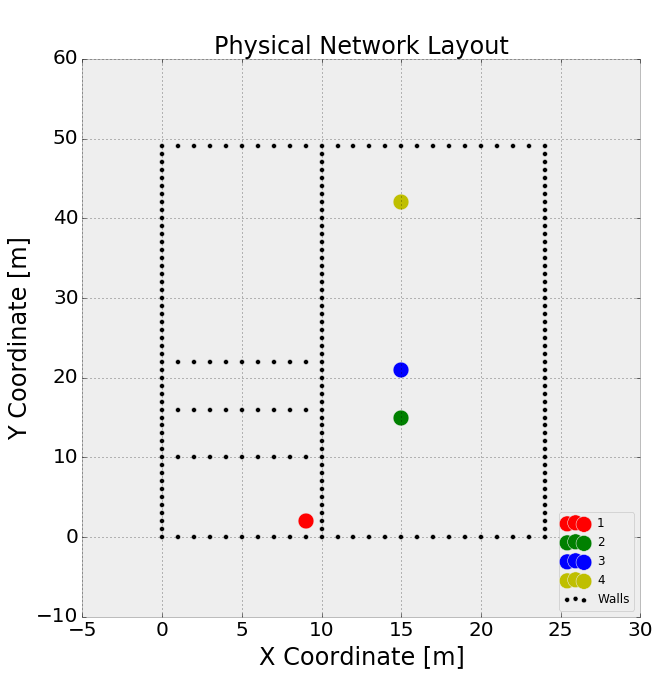


Coordinates of nodes
[[ 9  2]
 [15 15]
 [15 21]
 [15 42]]

Number of nodes: 4


Distance between nodes
[[  0.          14.31782106  19.92485885  40.44749683]
 [ 14.31782106   0.           6.          27.        ]
 [ 19.92485885   6.           0.          21.        ]
 [ 40.44749683  27.          21.           0.        ]]

Link margins
[[  0.           5.8409926    2.7429534   -3.27764652]
 [  5.8409926    0.          17.1048083    4.04055803]
 [  2.7429534   17.1048083    0.           6.22344742]
 [ -3.27764652   4.04055803   6.22344742   0.        ]]

Rooting table
[[ 0.  1.  1.  0.]
 [ 1.  0.  1.  1.]
 [ 1.  1.  0.  1.]
 [ 0.  1.  1.  0.]]

Available Routes

Routes from node 1

Node 1 - Node 2: 
[1 2]
[1 3 2]
[1 3 4 2]

Node 1 - Node 3: 
[1 2 3]
[1 2 4 3]
[1 3]

Node 1 - Node 4: 
[1 2 3 4]
[1 2 4]
[1 3 2 4]
[1 3 4]

Routes from node 2

Node 2 - Node 1: 
[2 1]
[2 3 1]
[2 4 3 1]

Node 2 - Node 3: 
[2 1 3]
[2 3]
[2 4 3]

Node 2 - Node 4: 
[2 1 3 4]
[2 3 4]
[2 4]

Routes from node 3

N

In [10]:
random.seed(RANDOM_SEED)

#Create Simpy environment where each time step within the simulation environment corresponds to one millisecond in realtime
env = simpy.rt.RealtimeEnvironment(factor = 0.001, strict = False)

#create grid indicating physical network configuration
roots = network_layout(0, 25, 50)

roots.insert_wall()
# roots.borders()
roots.map_walls()

# addNode(env, x_coordinate, y_coordinate, home_id, capability(0/1/2))

# Add the Primary Controller of the network
# roots.addNode(env, 15, 2, 0, 0)
roots.addNode(env, 9, 2, 0, 0)
# roots.addNode(env, 7, 8, 0, 0)

# Add the Slaves contained within the network
roots.addNode(env, 15, 15, 0, 1) # Node 3
roots.addNode(env, 15, 21, 0, 1) # Node 4
roots.addNode(env, 15, 42, 0, 1) # Node 5

    
#display visual representation of network
roots.show_grid()




In [11]:

#Transmit individual packets with a delay between transmissions
env.process(roots.send_message(100))
env.process(roots.send_message(200))
env.process(roots.send_message(300))



<Process(send_message) object at 0x7fb6c0848f98>

In [12]:
print_network_statistics()

Successes: 0
Collisions: 0


In [13]:
try:
    env.run(until=10000)
    print('Simulation ran according to plan')
except RuntimeError:
    print('Simulation ran slow')


Start Node: 1
Target Node: 2

New transmission attempt 
Message ID: 1 
Sender: Node 1 
Target: Node 2


Node 1 is waiting for an ACK

Message 2 added to queue


Node 1 is waiting for an ACK

Message 3 added to queue


 Message sent from 1 to 2 at 119 

Packet transission time:  21.333  s 

Target Destination Reached!
Route Packet Travelled:  [1 2] 

 ACK sent from 2 to 1 at 140 

queue count:  2

Transmission Successful 
Message ID: 1

Round Trip Time:  54.921  ms 

Retransmission attempt
Message ID: 2 
Sender: Node 1 
Target: Node 2


Retransmission attempt
Message ID: 3 
Sender: Node 1 
Target: Node 2


Node 1 is waiting for an ACK

Message 3 added to queue


 Message sent from 1 to 2 at 175 

Packet transission time:  19.667  s 

Target Destination Reached!
Route Packet Travelled:  [1 2] 

Start Node: 1
Target Node: 3

New transmission attempt 
Message ID: 4 
Sender: Node 1 
Target: Node 3


Node 1 is waiting for an ACK

Message 4 added to queue


Node 1 is waiting for an ACK

Mess

In [14]:
print(roots.broadcast[3].neighbours)
print(roots.broadcast[2].neighbours)
print(roots.broadcast[1].neighbours)
print(roots.broadcast[0].neighbours)

[2, 3]
[1, 2, 4]
[1, 4, 3]
[2, 3]


In [15]:
a = []
len(a)

0